In [6]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist

batch_size = 100
original_dim = 784
img_rows, img_cols, img_channels = 28, 28, 1
latent_dim = 2
intermediate_dim = 100
epochs = 15
epsilon_std = 1.0

x = Input(shape=(original_dim,))
a = Reshape((img_rows, img_cols, img_channels))(x)
a = Conv2D(32, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(64, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(128, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Flatten()(a)
h = Dense(intermediate_dim, activation='relu')(a)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_fc = Dense(2048, activation='relu')
decoder_reshape = Reshape((128, 4, 4))
decoder_conv1 = Conv2DTranspose(64, 3)
decoder_bn1 = BatchNormalization()
decoder_activ1 = LeakyReLU()
decoder_conv2 = Conv2DTranspose(32, 3)
decoder_bn2 = BatchNormalization()
decoder_activ2 = LeakyReLU()
decoder_conv3 = Conv2DTranspose(1, 3)
decoder_flatten = Flatten()
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
a = decoder_fc(h_decoded)
a = decoder_reshape(a)
a = decoder_conv1(a)
a = decoder_bn1(a)
a = decoder_activ1(a)
a = decoder_conv2(a)
a = decoder_bn2(a)
a = decoder_activ2(a)
a = decoder_conv3(a)
a = decoder_flatten(a)
x_decoded_mean = decoder_mean(a)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 28, 28, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['reshape[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8853712143180083233
xla_global_id: -1
]


In [8]:
# train the VAE on fashion_fashion_fashion_mnist digits
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

vae.save('vae.h5')

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/15
600/600 [==============================] - 72s 118ms/step - loss: 287.0148 - val_loss: 278.8125
Epoch 2/15
600/600 [==============================] - 75s 126ms/step - loss: 270.1027 - val_loss: 271.5504
Epoch 3/15
600/600 [==============================] - 79s 132ms/step - loss: 266.4514 - val_loss: 267.5448
Epoch 4/15
600/600 [==============================] - 82s 137ms/step - loss: 264.4578 - val_loss: 265.1757
Epoch 5/15
600/600 [==============================] - 88s 147ms/step - loss: 263.0940 - val_loss: 263.7189
Epoch 6/15
600/600 [==============================] - 86s 144ms/step - loss: 262.1434 - val_loss: 264.3733
Epoch 7/15
600/600 [==============================] - 82s 136ms/step - loss: 261.2401 - val_loss: 262.3621
Epoch 8/15
600/600 [==============================] - 80s 133ms/step - loss: 260.5998 - val_loss: 262.7669
Epoch 9/15
600/600 [==============================] - 86s 143ms/step - loss: 260.

/Users/vincenzoincutti/Desktop/VAE-Latent-Space-Explorer/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 1s 7ms/step


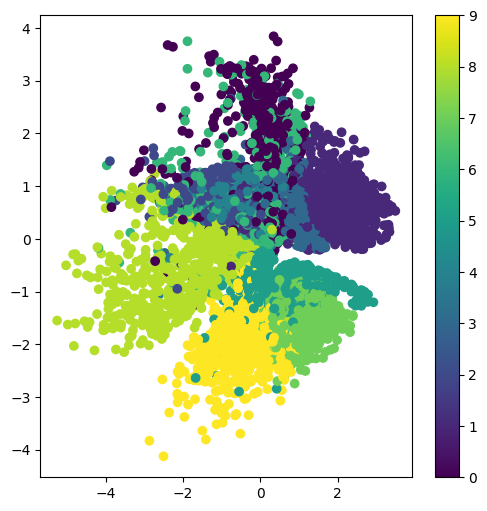

In [9]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')

In [10]:
import json
with open('../src/encoded.json', 'w') as outfile:
    data = [[float(x), float(y), int(l)] for [x, y], l in zip(x_test_encoded, y_test)]
    json.dump(data, outfile)


1/1 [==============================] - 0s 12ms/step


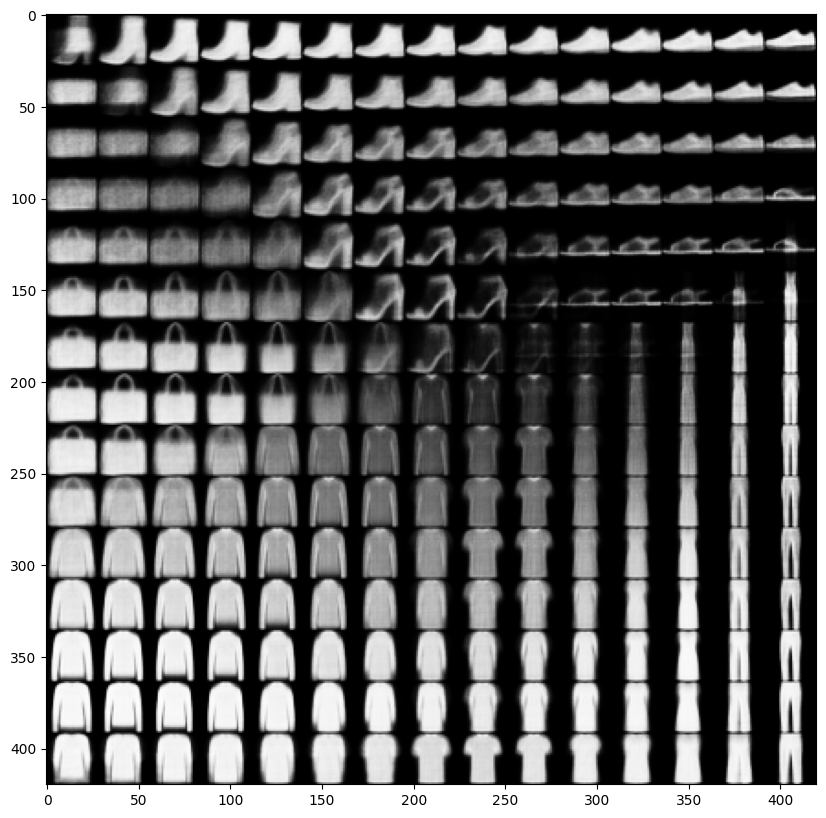

In [11]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_a = decoder_fc(_h_decoded)
_a = decoder_reshape(_a)
_a = decoder_conv1(_a)
_a = decoder_bn1(_a)
_a = decoder_activ1(_a)
_a = decoder_conv2(_a)
_a = decoder_bn2(_a)
_a = decoder_activ2(_a)
_a = decoder_conv3(_a)
_a = decoder_flatten(_a)
_x_decoded_mean = decoder_mean(_a)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

generator.save('generator.h5')

In [12]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(generator, '../public/models/generatorjs')

ModuleNotFoundError: No module named 'tensorflowjs'

In [15]:
from tensorflow.keras.saving import save_model
from tensorflow.saved_model import save

# save_model(generator, '../public/models/generatorjs')
save(generator, '../public/models/generatorjs')

INFO:tensorflow:Assets written to: ../public/models/generatorjs/assets


INFO:tensorflow:Assets written to: ../public/models/generatorjs/assets
